# Feature Engineering
The goals of a good feature are to simultaneously vary with what matters and be invariant with what doesn't. It is necessary to use background knowledge to design good features. Luckily, for many problems domains, there is already a vast literature of possible features and feature-types.

## Natural Language Processing
### Contextual Features
#### n-grams
Exploit context by using sequences of n words intead of single words. A litle context improves performance: bigrams are usually better than unigrams. Usually no gain for n > 3.
#### position information

### Linguistic features
#### Stemming
It helps to represent terms that occur in different morphological variants. Remove inflections that convey parts of speech, tense and number: increase recall by decreasing precision. Sometimes is too agresive. It can be a good idea to use it with n-grams because the latter increase precision. 
Stemming + N-gram == Noun phrase extraction?
Techniques:
* Morphological analysis: Porter's algorithm, fast but low quality
* Dictionary Lookup: WordNet: slow, but more powerful.

#### Lemmatization
#### Noun phrases
N-grams can be improved. It can be used with part-of-speech (lexical category) to find noun phrases. Noun phrases 
### Structural features
#### Structural Markups
#### Hypertext
### Feature Subset Selection
Using each word as a feature results in thousands of features. Many of them are irrelevant and redundant, and therefore can cause overfitting. Moreover removing them can increase efficiency.
#### Unsupervised FSS
##### Using Domain Knowledge
Some features may be known to be irrelevant or redundant.
##### Random Sampling
Select a random sample of the feature can be appropriate in the case of many weakly relevant features and in connection with ensemble methods.
##### Frequency-based
Most frequent features may be bad, they usually are numbers and stop words. However, too much pruning may hurts.
* Fixed Number: keep n most frequent words
* Thresholding: keep all words that occur at least k times
* TF-IDF

#### Supervised FSS
##### Filter approaches
Compute some measure for estimating the ability to discriminate between classes. Typically it consists in computing a **feature weight** and select the best n features. Problems can arise becasue of **redundant features** that will have similar weights and **dependant features**, features with low weights because they are consider alone. A good feature should **discriminate documents of different classes**.
###### Discrimination measures
* Information Gain
* Log-odds ration
* The chi-square test
##### Wrapper approaches
They consist in searching through the space of all possible feature subsets. Each search subset is tried with the learning algorithm. It can be very **inefficient**: many learning cycles necessary.
###### Forward selection
Simple search heuristic: Keep adding one feature at every step util classifier's accuracy ceases to improve.
###### Backward selection

    1. Start with full feature set F
    2. Try to remove algorithms

#### Machine Learning methods
### Feature Construction
### Latent Semantic Indexing
### Stop Lists
#### Removal of frequently occurring words
This words occur in all documents and are statistically irrelevant.

**Problems**
* Different meanings
* Important in phrases
* Polysemous words -> Poor precision


In [1]:
%matplotlib inline

In [6]:
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

digits = load_digits()
X = digits.images.reshape((len(digits.images), -1))
y = digits.target

# Create the RFE object and rank each pixel
svc = SVC(kernel="linear", C = 1)
rfe = RFE(estimator=svc, n_features_to_select = 1, step = 1)
rfe.fit(X,y)
ranking = rfe.ranking_.reshape(digits.images[0].shape)

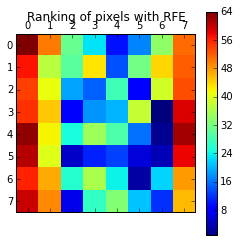

In [14]:
plt.matshow(ranking)
plt.colorbar()
plt.title("Ranking of pixels with RFE")

## Recursive feature elimination with cross-validation

In [5]:
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

Optimal number of features: 3


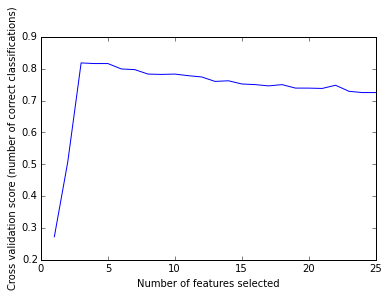

In [6]:
X, y = make_classification(n_samples=1000, n_features=25, n_informative=3,
                          n_redundant = 2, n_repeated = 0, n_classes = 8,
                          n_clusters_per_class = 1, random_state = 0)

svc = SVC(kernel='linear')
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(y,2), scoring='accuracy')
rfecv.fit(X,y)
print("Optimal number of features: %d" % rfecv.n_features_)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (number of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) +1), rfecv.grid_scores_)